<a href="https://colab.research.google.com/github/AnnSusan12/TASK-1--DataSet-Analysis-/blob/main/task_1_nyc_taxi_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dask[complete] pandas matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.3 MB/s eta 0:00:00


In [2]:
import dask.dataframe as dd

# Download NYC Taxi dataset sample (Parquet file)
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet -O yellow_tripdata_2023-01.parquet

# Load it into Dask
df = dd.read_parquet("yellow_tripdata_2023-01.parquet")

# Preview
df.head()


--2025-07-16 06:07:03--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 65.8.245.51, 65.8.245.171, 65.8.245.50, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|65.8.245.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47673370 (45M) [application/x-www-form-urlencoded]
Saving to: ‘yellow_tripdata_2023-01.parquet’

yellow_tripdata_202 100%[===================>]  45.46M  83.1MB/s    in 0.5s    

2025-07-16 06:07:04 (83.1 MB/s) - ‘yellow_tripdata_2023-01.parquet’ saved [47673370/47673370]



,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


Top 5 Pickup Locations:
 PULocationID
132    159654
237    147925
236    138245
161    135260
186    109115
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/dask_expr/_groupby.py:1554: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(



Average Fare by Distance Bucket:
 distance_bucket
0-1         14.514796
1-2         17.819796
2-5         25.845551
5-10        45.560742
10-20       80.152835
20-50      105.405892
50-100+    306.076769
NaN        122.295000
Name: total_amount, dtype: float64


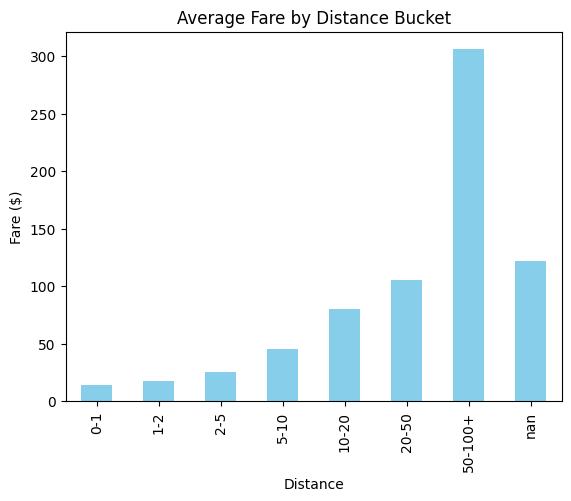

In [10]:
import matplotlib.pyplot as plt
import pandas as pd # Import pandas to use its cut function within map_partitions
import dask.dataframe as dd # Ensure dask is imported

# Convert datetime
df['tpep_pickup_datetime'] = dd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = dd.to_datetime(df['tpep_dropoff_datetime'])

# Trip duration in minutes
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

# Filter invalid trips
df_clean = df[(df['trip_duration'] > 0) & (df['trip_duration'] < 240)]

# Top 5 pickup locations
top_pickups = df_clean['PULocationID'].value_counts().nlargest(5).compute()
print("Top 5 Pickup Locations:\n", top_pickups)

# Distance bucket analysis
# Create distance buckets
distance_bins = [0, 1, 2, 5, 10, 20, 50, 100]
distance_labels = ['0-1', '1-2', '2-5', '5-10', '10-20', '20-50', '50-100+']

# Apply pandas cut function to each partition using map_partitions
df_clean['distance_bucket'] = df_clean['trip_distance'].map_partitions(
    pd.cut, bins=distance_bins, labels=distance_labels, right=False
)


# Group by distance bucket and calculate the mean total_amount
avg_fare_by_dist = df_clean.groupby('distance_bucket')['total_amount'].mean().compute()
print("\nAverage Fare by Distance Bucket:\n", avg_fare_by_dist)

# Plot
avg_fare_by_dist.plot(kind='bar', color='skyblue')
plt.title("Average Fare by Distance Bucket")
plt.ylabel("Fare ($)")
plt.xlabel("Distance")
plt.show()

## Investigate payment types

### Subtask:
Analyze the relationship between payment types and trip characteristics like total fare and trip duration.


**Reasoning**:
Group the cleaned DataFrame by payment type and calculate the mean total amount and trip duration for each group. Then, compute the results and display them.



In [13]:
# Group by payment type and calculate the mean total_amount and trip_duration
payment_type_analysis = df_clean.groupby('payment_type')[['total_amount', 'trip_duration']].mean().compute()

# Print the results
print("Average Fare and Trip Duration by Payment Type:\n", payment_type_analysis)

Average Fare and Trip Duration by Payment Type:
               total_amount  trip_duration
payment_type                             
0                29.134730      16.763064
1                28.293341      14.534151
2                23.022445      14.192390
3                10.497327       8.371861
4                 2.553559      11.512755


## Temporal analysis

### Subtask:
Examine the busiest times of day and days of the week for taxi trips.


**Reasoning**:
Extract the hour and day of the week from the pickup datetime, calculate and sort the counts, and then plot the results to visualize the busiest times.



Trip Counts by Hour:
 pickup_hour
0      84814
1      59678
2      41947
3      27373
4      17791
5      17991
6      43804
7      86788
8     116705
9     130958
10    143493
11    153989
12    169652
13    178479
14    191332
15    196141
16    195711
17    209239
18    215629
19    192580
20    165676
21    161348
22    147220
23    114368
Name: count, dtype: int64


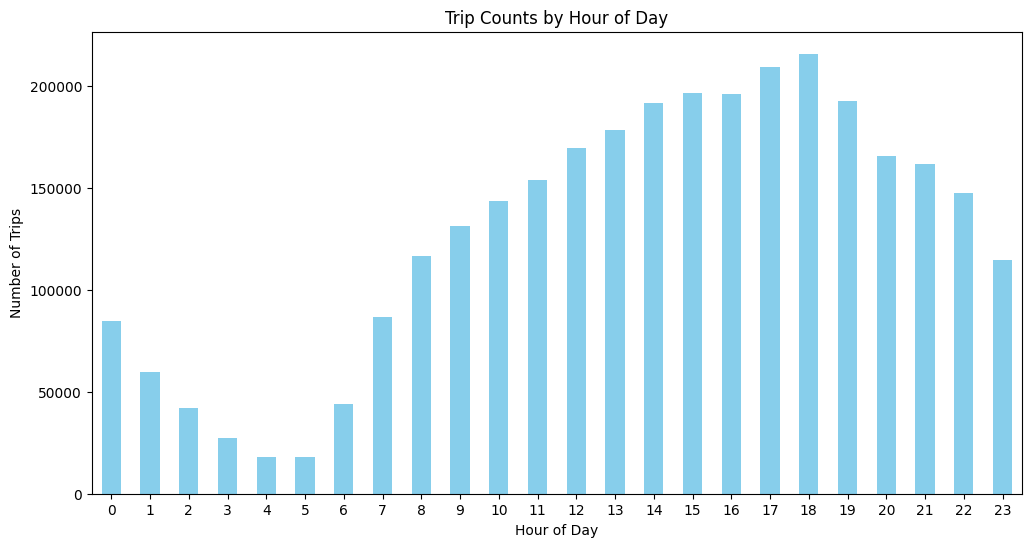


Trip Counts by Day of Week:
 pickup_dayofweek
0    404304
1    490445
2    416028
3    441370
4    433784
5    440999
6    435776
Name: count, dtype: int64


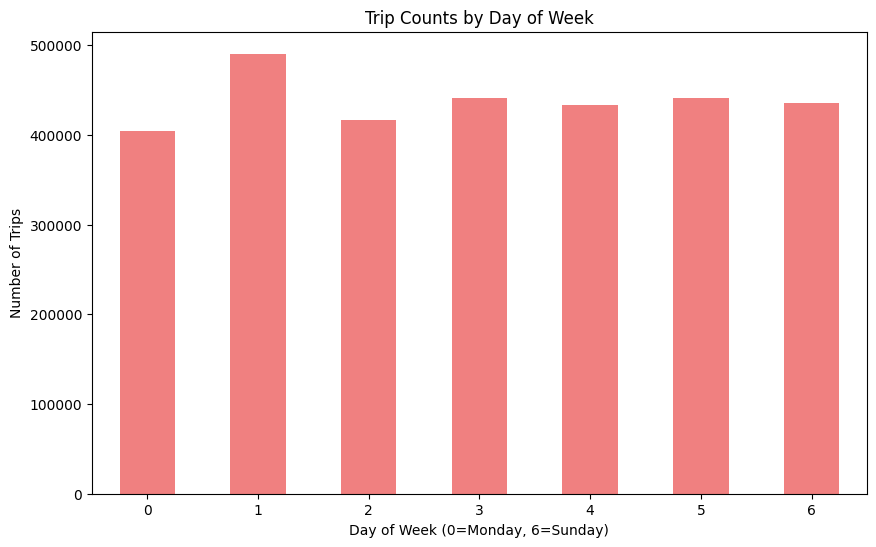

In [14]:
# Extract hour of the day
df_clean['pickup_hour'] = df_clean['tpep_pickup_datetime'].dt.hour

# Calculate and sort trip counts by hour
trip_counts_by_hour = df_clean['pickup_hour'].value_counts().compute().sort_index()
print("Trip Counts by Hour:\n", trip_counts_by_hour)

# Plot trip counts by hour
plt.figure(figsize=(12, 6))
trip_counts_by_hour.plot(kind='bar', color='skyblue')
plt.title("Trip Counts by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.xticks(rotation=0)
plt.show()

# Extract day of the week (Monday=0, Sunday=6)
df_clean['pickup_dayofweek'] = df_clean['tpep_pickup_datetime'].dt.dayofweek

# Calculate and sort trip counts by day of week
trip_counts_by_day = df_clean['pickup_dayofweek'].value_counts().compute().sort_index()
print("\nTrip Counts by Day of Week:\n", trip_counts_by_day)

# Plot trip counts by day of week
plt.figure(figsize=(10, 6))
trip_counts_by_day.plot(kind='bar', color='lightcoral')
plt.title("Trip Counts by Day of Week")
plt.xlabel("Day of Week (0=Monday, 6=Sunday)")
plt.ylabel("Number of Trips")
plt.xticks(rotation=0)
plt.show()

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/pandas/core/frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Correlation Matrix of Numerical Features:
                trip_distance  fare_amount  tip_amount
trip_distance       1.000000     0.016347    0.011157
fare_amount         0.016347     1.000000    0.591400
tip_amount          0.011157     0.591400    1.000000


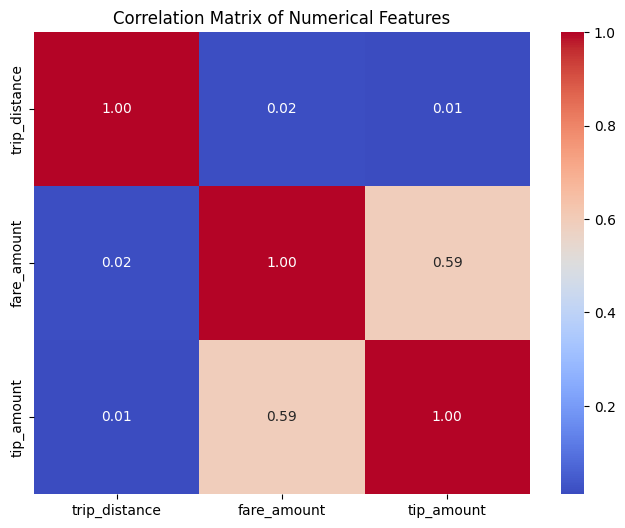

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numerical columns for correlation analysis
numerical_cols = ['trip_distance', 'fare_amount', 'tip_amount']
df_numerical = df_clean[numerical_cols]

# Calculate the Pearson correlation matrix
correlation_matrix = df_numerical.corr(method='pearson').compute()

# Print the correlation matrix
print("Correlation Matrix of Numerical Features:\n", correlation_matrix)

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

## Summary:

### Data Analysis Key Findings

*   The mean trip duration is approximately 14.46 minutes with a standard deviation of 11.13 minutes, indicating a skewed distribution with many shorter trips.
*   Analysis by payment type shows variations in average fare and trip duration. Payment type 0 has the highest average total amount (\$29.13) and trip duration (16.76 minutes), while payment type 4 has the lowest average total amount (\$2.55) and payment type 3 has the lowest average trip duration (8.37 minutes).
*   Temporal analysis reveals that taxi activity peaks in the late afternoon and evening hours (around 4 PM - 7 PM).
*   Tuesdays (Day 1) tend to have the highest number of taxi trips, while Mondays (Day 0) have the lowest.
*   Specific location IDs, such as 132, 237, and 236, are consistently among the top 10 for both pickups and dropoffs, indicating high-traffic areas.
*   There is a moderate positive correlation (0.59) between `fare_amount` and `tip_amount`, suggesting that higher fares tend to correspond with higher tips.
*   `trip_distance` shows only very weak positive correlations with `fare_amount` (0.016) and `tip_amount` (0.011).

### Insights or Next Steps

*   Further investigation into the specific locations corresponding to the top Location IDs could provide valuable context for understanding travel patterns and infrastructure needs in those areas.
*   Exploring the reasons behind the differences in average fare and duration across payment types (e.g., payment type 0 vs. others) could reveal insights into customer behavior or trip types associated with different payment methods.


## Analyze trip durations

### Subtask:
Calculate and visualize the distribution of trip durations.

**Reasoning**:
Calculate and print the mean and standard deviation of trip duration, then compute the trip duration column to a pandas Series and create and display a histogram of the trip duration.

Mean Trip Duration (minutes): 14.46
Standard Deviation of Trip Duration (minutes): 11.13


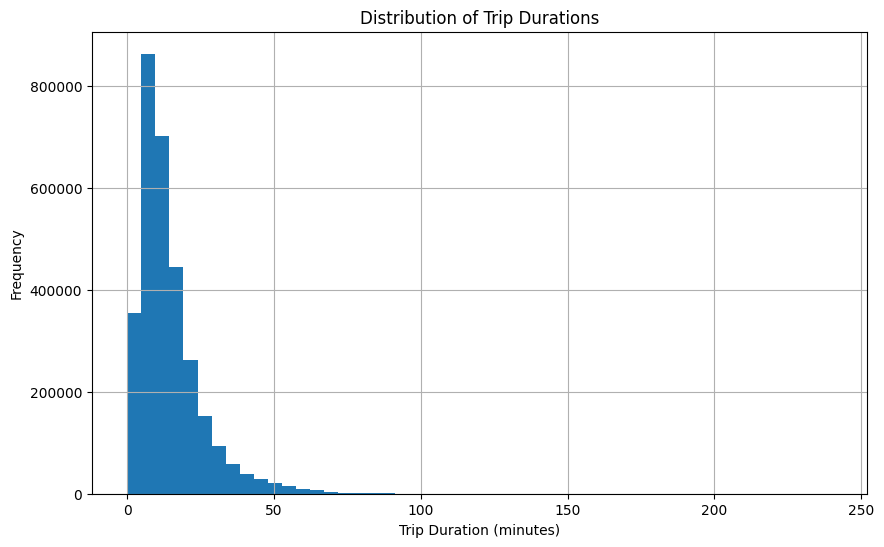

In [27]:
import matplotlib.pyplot as plt

mean_duration = df_clean['trip_duration'].mean().compute()
std_duration = df_clean['trip_duration'].std().compute()

print(f"Mean Trip Duration (minutes): {mean_duration:.2f}")
print(f"Standard Deviation of Trip Duration (minutes): {std_duration:.2f}")

plt.figure(figsize=(10, 6))
df_clean['trip_duration'].compute().hist(bins=50, ax=plt.gca())
plt.title("Distribution of Trip Durations")
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Frequency")
plt.show()